# Spike Sorting Algorithm 

In [1]:
#First let's get the imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  


%matplotlib inline

In [2]:
#Function to read two columns from file
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return x, y

In [3]:
#Function to smooth signals *well i eventually didn't use it*
def smoothing(squares,window_size=48):
    
    N=window_size
    smooth=np.zeros((squares.shape[0]))
    for i in range(N//2,(squares.shape[0]-(N//2))):
        
        sum=0
        for j in range (i-(N//2), i+(N//2)):
            
            sum=sum+squares[j]
        smooth[i]=(1/N)*sum
    return smooth

In [4]:
#Function to get the peaks, the peaks' indicies and the whole spikes
#What my algorithm does is that it iterates over the whole electrode list by a step of 48
#For each window of 48 samples we get the max value, if it exceeds the threshold this is a spike peak we're lookin for
# append the peak value in the peaksss list, and the index in the peaksssindex list
#append the spike values in the spikes list i.e. 24 sample before the peak and 24 sample after
#return the 3 lists as numpy arrays
def getSpikes(electrodeAbs , electrode,thresh , noSamples=48):
    
    
    spikes=[]
    peaksss=[]
    peaksssIndex=[]
        
    for i in range(0,len(electrode)-noSamples, noSamples):
        
        peak= max(electrodeAbs[i:i+noSamples])
        #print(peak)
        
        if peak >= thresh :
            peaksss.append(peak)
            #print('YES BIGGER THAN THRESH')
            peakIndex=np.where(electrodeAbs[i:i+noSamples]== peak)
            peakIndex[0][0]+=i
            peaksssIndex.append(peakIndex[0][0])

            #print('I AM PEAK INDEXXXXXXX ', peakIndex,peakIndex[0][0])
            #np.append(spikes,electrode[peakIndex[0][0]-noSamples//2,peakIndex[0][0]+noSamples//2])
            #print(spikes)
            #print(electrode[(29-noSamples//2):(29+noSamples//2)])
            spikes.append(electrode[(peakIndex[0][0]-noSamples//2):(peakIndex[0][0]+noSamples//2)])
        else:
            pass
    return np.array([spikes]), np.array([peaksss]), np.array([peaksssIndex])

In [10]:

#THIS IS THE MAIN REQUIRED FUNCTION i.e. the pipeline of the assignment
def spikeSort(fileName , samplingRate=24414, noElectrode=1 ,sdMultiple=3.5, noClusters=2):
    #Read the electrodes data
    electrode1,electrode2 = Read_Two_Column_File(fileName)
    #Choose which electrode's data to process on
    if noElectrode==2:
        electrode=electrode2
    else:
        electrode=electrode1
    
    #some x values to use in plotting.. or not..
        
    x_values = range(0,len(electrode))
    
    #Get the absolute values of the electrode data
    electrodeAbs= np.absolute(electrode)
    
    #plot the electrode's raw data and the abosulte as well
    f1, (ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
    f1.tight_layout()

    ax1.plot(x_values,electrode)
    text='Electrode'+str(noElectrode)+ 'Raw'
    ax1.set_title(text,fontsize=30)
    
    text='Electrode'+str(noElectrode)+'Absoulte'
    ax2.plot(x_values,electrodeAbs)
    ax2.set_title(text,fontsize=30)
    
    
    
    #Calculate the standard deviation 'sd' and the threshold of the peaks
    sd = np.std(electrode[:500])
    
    thresh= sd *sdMultiple
    
    #call the getSpikes() function
    
    spikes,peaksss, peaksssIndex=getSpikes (electrodeAbs,electrode, thresh)
    
    #Apply dimensionality reduction on the detected spikes data
    
    pca_elec = PCA(n_components=2)
    electrode_decomposed_spike_values= pca_elec.fit_transform(spikes[0])
    
    
    #Apply Kmeans algorithm to cluster the data points we visualized using the pca 
    #*we try out different n_clusters values till we find the most suitable one*
    
    kmeans = KMeans(n_clusters=noClusters)   #<------------------------------  
    kmeans.fit(electrode_decomposed_spike_values)
    

    #PLOT the clustered data to check out if the number of clusters really fits the data
    f2, (ax3,ax4)=plt.subplots(1,2,figsize=(24,9))
    f2.tight_layout()

    for x in spikes:
        
        ax3.plot(x)
    #no need for this line actually.. 
    ax3.set_title('Aligned Spikes',fontsize=30)

    ax4.set_title('Feature Space',fontsize=30)
    
    ax4.scatter(electrode_decomposed_spike_values[:,0],electrode_decomposed_spike_values[:,1], c=kmeans.labels_, cmap='rainbow')  
    ax4.axis((-0.00015, 0.00025, -0.00015, 0.00025))
    
    
    
    #_______________________
    
    #Apply kmeans again but this time on the first 20,000 samples to fill in the requirements of the assignment
    kmeans = KMeans(n_clusters=noClusters)  #<------------------------------
    spikes,peaksss, peaksssIndex=getSpikes (electrodeAbs[:20000],electrode[:20000], thresh)
    #return a list of labels to each spike based on the clustering
    listaa=kmeans.fit_predict(spikes[0])
#     sum0=[]
#     counter0=0
#     sum1=0
#     counter1=0
#     sum2=0
#     counter2=0
#     sum3=0
#     counter3=0

    #declare some lists to fill in while iterating 
    timeStamp0=[]
    timeStamp1=[]
    timeStamp2=[]
    timeStamp3=[]
    mean0=[]
    mean1=[]
    mean2=[]
    mean3=[]
    #plot the first 20,000 electrode values
    f3, (ax5)=plt.subplots(1,figsize=(24,9))
    f1.tight_layout()

    ax5.plot(electrode[:20000])
    text='Electrode'+str(noElectrode)
    ax5.set_title(text,fontsize=30)
    
#     text='Electrode'+str(noElectrode)+'Absoulte'
#     ax2.plot(x_values,electrodeAbs)
#     ax2.set_title(text,fontsize=30)
    
    for i in range(0,spikes.shape[1]):
        #IF the spike belongs to cluster 0
        if listaa[i]==0:
            #print(listaa[i])
            
            #if condition to point out if the peak is positive or negative
            #This is to be able to plot it in the #IF the spike belongs to cluster 0
            #ax5. plots the points on the previous electrode plot
            if electrode[peaksssIndex[0][i]] != peaksss[0][i]:


                ax5.plot(peaksssIndex[0][i],(-1*peaksss[0][i]), '*',color='green' ,markerfacecolor='green')
            else:
                ax5.plot(peaksssIndex[0][i],(peaksss[0][i]), '*',color='green' ,markerfacecolor='green')
                
            #append the spikes value to the mean list, to compute the mean when the iterations are over    
            mean0.append(spikes[0][i])

            timeStamp0.append(peaksssIndex[0][i])
            #print(peaksss[0][i])
        #IF the spike belongs to cluster 1  
        #The rest is the same as the previous
        elif listaa[i]==1:
            #print(listaa[i])
            if electrode[peaksssIndex[0][i]] != peaksss[0][i]:
                ax5.plot(peaksssIndex[0][i],(-1*peaksss[0][i]), '*', color='blue',markerfacecolor='blue')
            else: 
                ax5.plot(peaksssIndex[0][i],peaksss[0][i], '*', color='blue',markerfacecolor='blue')
                
            mean1.append(spikes[0][i])

            timeStamp1.append(peaksssIndex[0][i])
        #IF the spike belongs to cluster 2
        elif listaa[i]==2:
            #print(listaa[i])
            if electrode[peaksssIndex[0][i]] != peaksss[0][i]:
                ax5.plot(peaksssIndex[0][i],(-1*peaksss[0][i]), '*',color='red' ,markerfacecolor='red')
            else:
                ax5.plot(peaksssIndex[0][i],(peaksss[0][i]), '*',color='red' ,markerfacecolor='red')

                
            mean2.append(spikes[0][i])

            timeStamp2.append(peaksssIndex[0][i])
        #IF the spike belongs to cluster 3
        elif listaa[i]==3:
            #print(listaa[i])
            if electrode[peaksssIndex[0][i]] != peaksss[0][i]:
                ax5.plot(peaksssIndex[0][i],(-1*peaksss[0][i]), '*',color='yellow',markerfacecolor= 'yellow')
            else:
                ax5.plot(peaksssIndex[0][i],peaksss[0][i], '*',color='yellow',markerfacecolor= 'yellow')
                
            mean3.append(spikes[0][i])
            timeStamp3.append(peaksssIndex[0][i])

#     print('mean of spike of class 0' , sum0/counter0)
#     print('mean of spike of class 1' , sum1/counter1)
#     print('mean of spike of class 2' , sum2/counter2)
#     print('mean of spike of class 3' , sum3/counter3)
    


#Calculate the mean of the spikes of each cluster
    mean00= np.mean(mean0, axis=0)
    mean11= np.mean(mean1, axis=0)
    mean22= np.mean(mean2, axis=0)
    mean33= np.mean(mean3, axis=0)


#     f4, (ax7,ax8)=plt.subplots(1,2,figsize=(24,9))
#     f4.tight_layout()

#     ax7.plot(mean00)
#     text='neuron0'
#     ax7.set_title(text,fontsize=30)

#     text='neuron1'
#     ax8.plot(mean11)
#     ax8.set_title(text,fontsize=30)


#     f5, (ax9,ax10)=plt.subplots(1,2,figsize=(24,9))
#     f5.tight_layout()

#     ax9.plot(mean22)
#     text='neuron2'
#     ax9.set_title(text,fontsize=30)

#     text='neuron3'
#     ax10.plot(mean33)
#     ax10.set_title(text,fontsize=30)


#PLOT the templates

    f4, (ax7)=plt.subplots(1,figsize=(24,9))
    f4.tight_layout()

    ax7.plot(mean00)
    ax7.plot(mean11)
    ax7.plot(mean22)
    ax7.plot(mean33)
    text='Template'
    ax7.set_title(text,fontsize=30)










    
    
    
    return np.array( [timeStamp0,timeStamp1,timeStamp2,timeStamp3]), np.array([mean00, mean11,mean22,mean33])

### - Here you can try out different combinations and check the results .
### - Type 1 in 'noElectrode' field to process on the data of Electrode1 . 
### - Type 2 in 'noElectrode' field to process on the data of Electrode2 . 
### - Type 3.5 in the 'sdMultiples' field to compute the threshold =sd *3.5 . 
### - Type 5 in the 'sdMultiples' field to compute the threshold =sd *5 . 
### - Type 2,3,4 or whatever you think is suitable in the 'noClusers' field to change the number of clusters of the neurons . 

### Note: This may take a while !

### Note: If the number of clusters you choose is less than 4, you will see a warning, just ignore it, thanks.

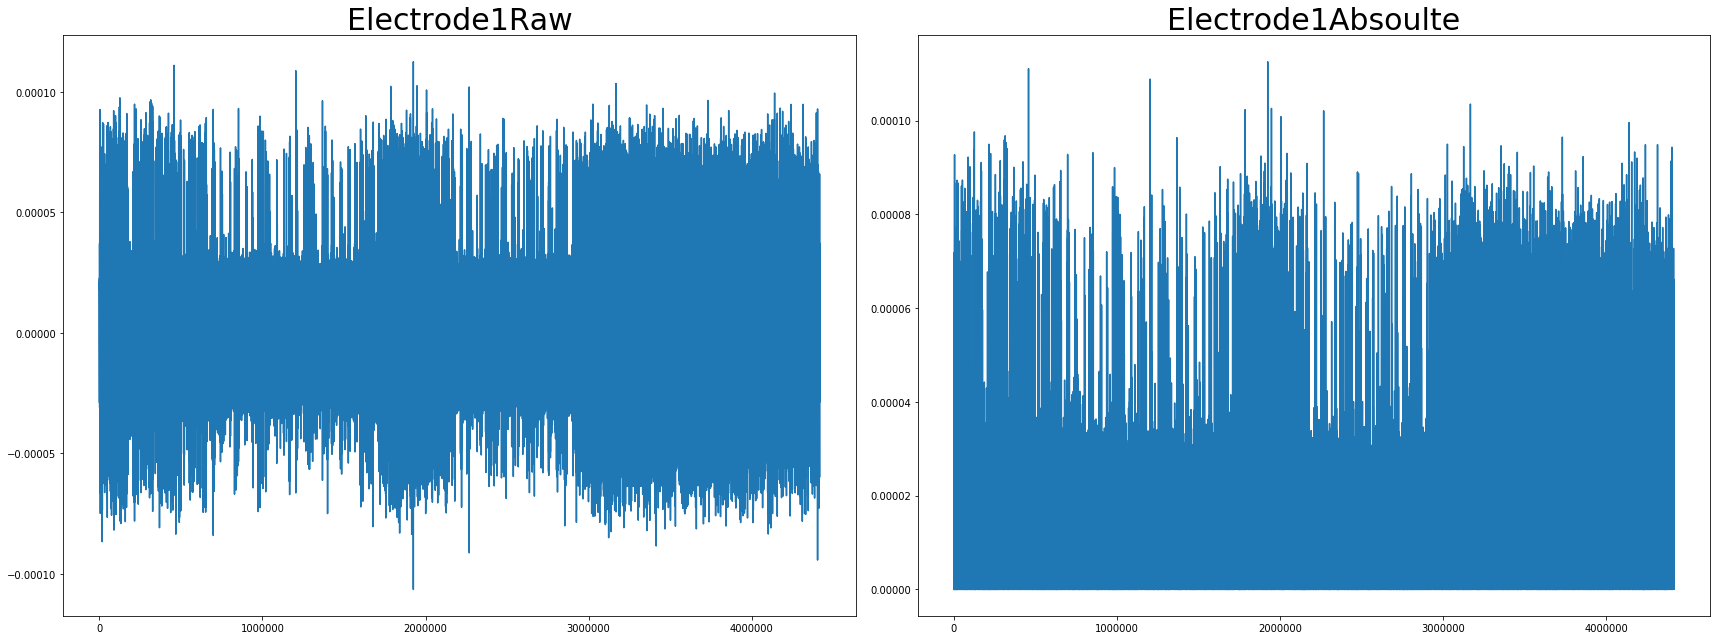

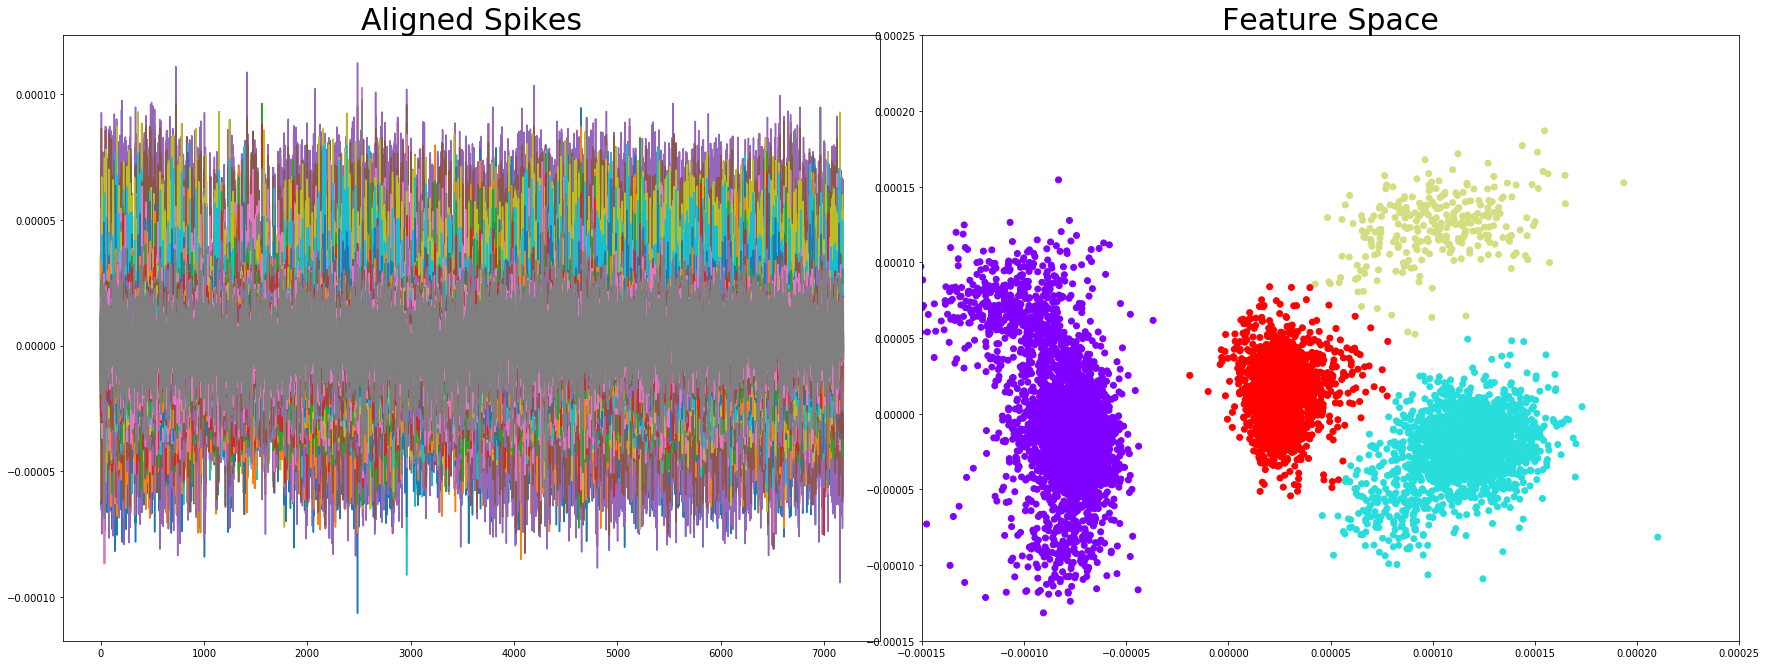

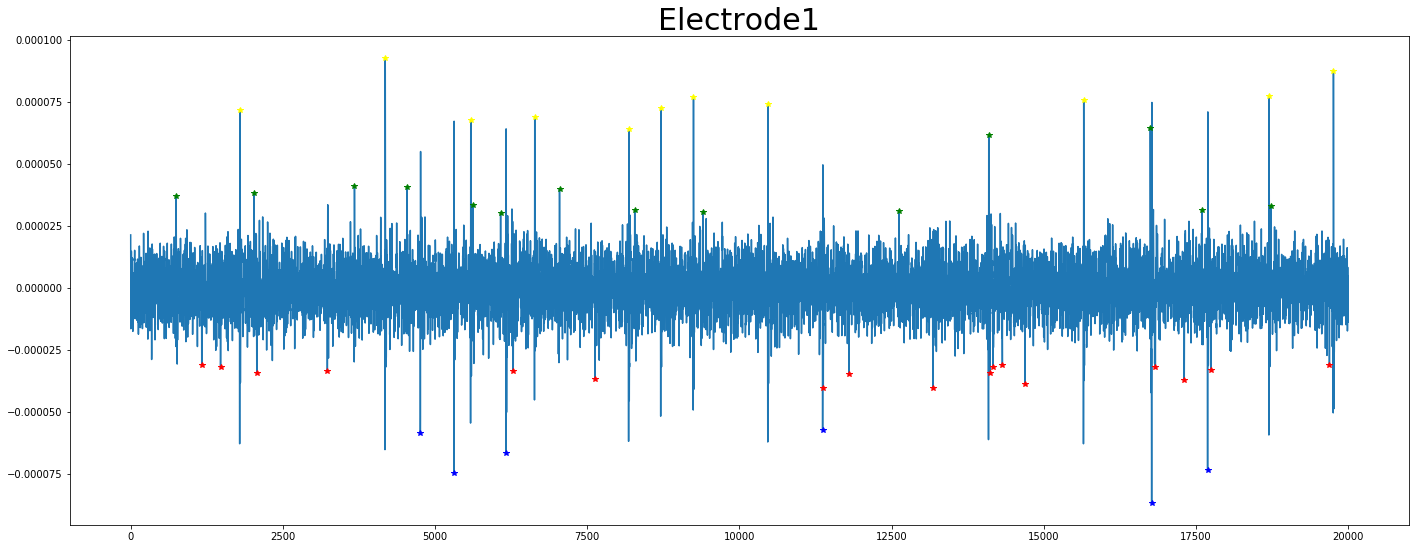

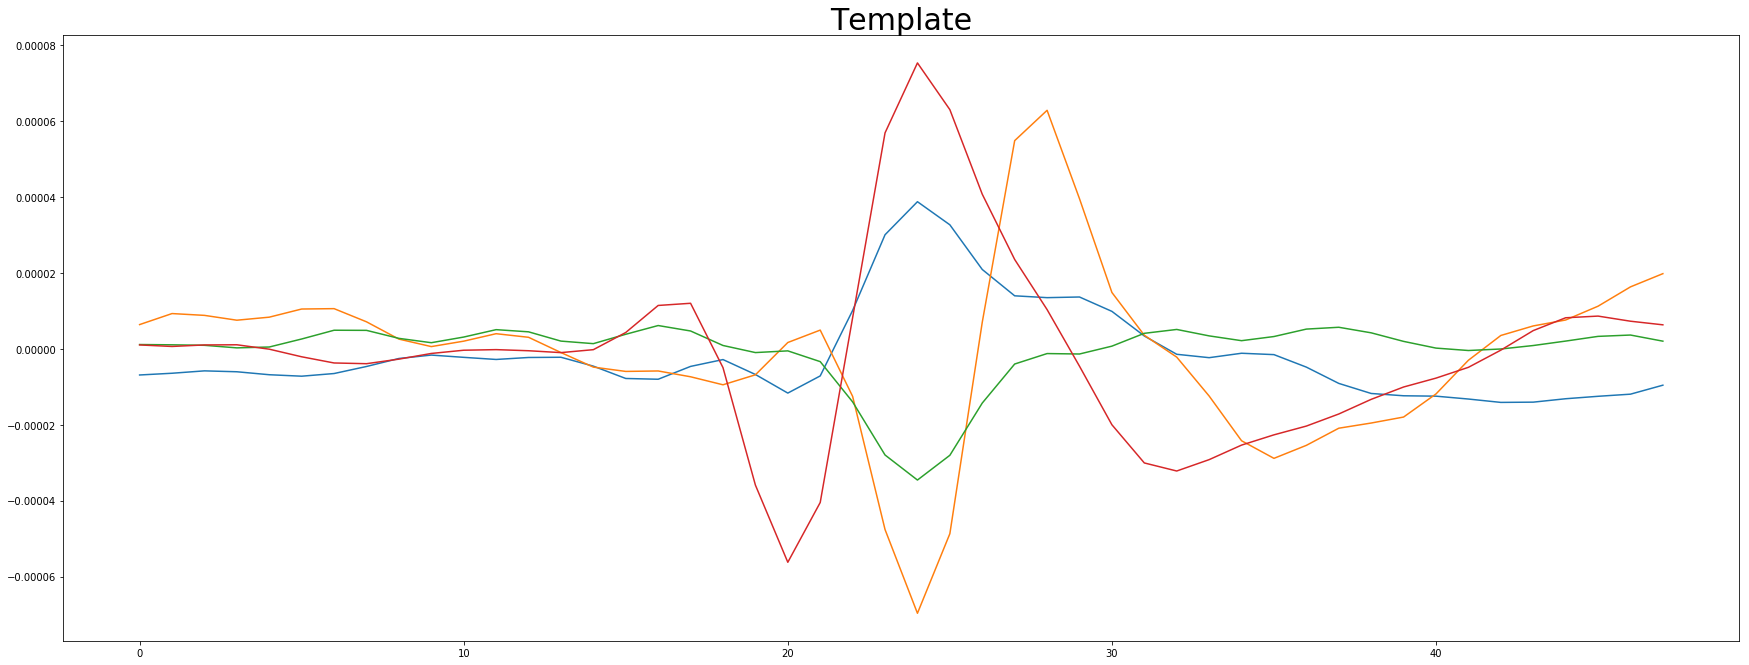

In [13]:

timeStamp, Mean=spikeSort('Data.txt',noElectrode=1 ,sdMultiple=3.5, noClusters=4)
